Start from design and AF2 models of all parents selected by AF2, nstruct 10, with PPI upweighter

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: dig67


In [1]:
import os, stat

ala_pen = 2
met_pen = 1
np_pen = 3

nstruct = 15
def create_tasks(selected):
    with open(selected, "r") as f:
        for i, line in enumerate(f):
            tasks = {"-s": line.rstrip()}
            tasks["-ala_pen"] = ala_pen
            tasks["-met_pen"] = met_pen
            tasks["-np_pen"] = np_pen
            yield tasks

selected_af2 = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected.list"
selected_des = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design.list"
run_str = 'run_4'

msd_py = f"/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/{run_str}/msd_checkpoint.py"

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

slurm_dir = os.path.join(os.getcwd(), '05_two_state/slurm_logs')

tasklist = f"05_two_state/{run_str}/05_msd_tasks.cmds"
run_sh = """#!/usr/bin/env bash \n#SBATCH -J 05_two_state \n#SBATCH -e {slurm_dir}/05_two_state-%J.err \n#SBATCH -o {slurm_dir}/05_two_state-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=10G \n
source activate /projects/crispy_shifty/envs/crispy\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
    slurm_dir=slurm_dir, queue='backfill', jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
)
shell = f"05_two_state/{run_str}/05_msd.sh"
with open(shell, "w+") as f:
    print(run_sh, file=f)
st = os.stat(shell)
os.chmod(shell, st.st_mode | stat.S_IEXEC)
with open(tasklist, "w+") as f:
    for _ in range(nstruct):
        for tasks in create_tasks(selected_af2):
            tasks["-subfolder"] = 'af2_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)
        for tasks in create_tasks(selected_des):
            tasks["-subfolder"] = 'design_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
print(f"sbatch -a 1-$(cat {tasklist} | wc -l) {shell}")

Run the following commands
sbatch -a 1-$(cat 05_two_state/run_4/05_msd_tasks.cmds | wc -l) 05_two_state/run_4/05_msd.sh


In [2]:
# %%time

# retrieve the JSONs containing scores

import json

for model_type in ['af2', 'design']:

    output_paths = glob(f"05_two_state/run_4/{model_type}_decoys/*.json")

    scores = {}
    errors = []

    for test in tqdm(output_paths):
        key = test.replace("json", "pdb")
        try:
            with open(test, "r") as f:
                values = json.load(f)
            scores[key] = values
        except json.JSONDecodeError:
            errors.append(test)

    print(len(errors))

    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.T
    output_path = "05_two_state/run_4"
    output_file = os.path.join(output_path, f"{model_type}_scores.json")
    scores_df.to_json(output_file)

  0%|          | 0/16798 [00:00<?, ?it/s]

0


  0%|          | 0/7220 [00:00<?, ?it/s]

0


In [2]:
def histplot_df(df, hue_col=None, hue_order=None):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for ax, col in zip(axs.flatten(),cols):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
            hue=hue_col,
            hue_order=hue_order,
        )

    plt.tight_layout()

In [3]:
def print_scores(df):
    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        "parent",
    ]
    print_df = df[cols]

    from IPython.display import display
    with pd.option_context(
        # 'display.max_rows', 5,
        'display.max_columns', None,
        # 'display.width', 1000,
        # 'display.precision', 3,
        # 'display.colheader_justify', 'left'
    ):
        display(print_df)

In [4]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [5]:
def copy_designs(df, out_dir):
    import os
    import shutil
    # Copy designs to a folder
    os.makedirs(out_dir, exist_ok=True)
    
    keys = ['parent',
            'Y-X',
            'sap_A_X',
            'sap_B_X',
            'sap_Y',
            'sc_int_Y',
            'vbuns_Y',
            'wnm_hlx_X',
            'wnm_hlx_Y',
            'wnm_all_A_X',
            'wnm_all_B_X',
            'wnm_all_A_Y',
            'wnm_all_B_Y',
           ]

    for index, row in df.iterrows():
        filename = out_dir
        for key in keys:
            val = row[key]
            if type(val) != str:
                val = f'_{val:.03f}'
            filename += val
        filename += '.pdb'
    #     print(filename)
        shutil.copy(index, filename)

In [6]:
def get_parents(df):
    parents = []
    for key, row in df.iterrows():
        parent = row['parent']
        if parent not in parents:
            parents.append(parent)
    print(len(parents))
    return parents

#### Analyze and filter MSD starting from AF2 models ####

In [7]:
output_path = "05_two_state/run_4"
output_file = os.path.join(output_path, "af2_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y
05_two_state/run_4/af2_decoys/ebd05b9317bd3702fff9ce331f8c90a59a03001435214a67.pdb,XAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAAGBAAA...,222.469345,44.109371,44.109371,loop_remodel,loop_remodel,-1.0,340.364197,559.456909,...,-934.840576,-904.914856,0,2,0.273968,0.801046,0.322196,0.421473,0.097108,0.144357
05_two_state/run_4/af2_decoys/f341e415f164086e8f47dc021c364d83be46ad6c7cb54b82.pdb,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,124.985054,61.185627,61.185627,loop_match,loop_match,-1.0,412.533051,601.542358,...,-1059.034912,-1004.991272,2,3,0.269729,0.477070,0.231012,0.442705,0.106552,0.122451
05_two_state/run_4/af2_decoys/d22f5909838ce16ec2336e68bd0107180fa1c31110aa9996.pdb,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,124.986877,61.185627,61.185627,loop_match,loop_match,-1.0,562.327698,741.352112,...,-1057.148193,-992.044250,0,3,0.230951,0.949901,0.312372,0.435266,0.122512,0.183364
05_two_state/run_4/af2_decoys/d4d28ad2e4c59570f7cceb0d738bbbb02128427763c301e0.pdb,XAAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAA...,489.982300,58.995354,58.995125,loop_match,loop_remodel,-1.0,655.691650,991.115112,...,-1274.839111,-1196.360718,0,4,0.345356,1.281243,0.332068,0.801602,0.111256,0.204896
05_two_state/run_4/af2_decoys/98ddb7b6e28dccac5f21b267a695f886ae6000b3c48074c6.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,747.533386,74.775955,74.775955,loop_match,loop_match,-1.0,534.091064,704.185669,...,-1131.587524,-1105.363647,0,3,0.372503,0.723214,0.340746,0.894870,0.105323,0.267853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_4/af2_decoys/3150ded495d250892f98e9293b1c8e6c1e4b674dbaa77c30.pdb,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,2127.943604,52.802925,53.006519,loop_match,loop_match,-1.0,402.097351,804.349487,...,-987.978638,-980.853943,1,3,0.310572,0.671643,1.703938,1.425554,0.093675,0.161123
05_two_state/run_4/af2_decoys/1c6edd8e736fe60c9511ae5a18db723b2a4ea57f67e60cdf.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,163.615021,64.283478,64.283478,loop_match,loop_match,-1.0,616.323242,783.551636,...,-1200.768555,-1138.474243,0,6,0.361381,0.559957,0.333761,1.412474,0.123035,0.283380
05_two_state/run_4/af2_decoys/8bcfe51e6738b71ab233e6659e9386c053cea9525102ff09.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,1222.480347,74.775955,74.775955,loop_match,loop_match,-1.0,465.045410,810.741028,...,-1168.337036,-1198.527222,0,3,0.337542,0.594589,0.425264,0.831738,0.197512,0.170661
05_two_state/run_4/af2_decoys/096240c719a800fc0392e7988968fae7c3e03f1d0faf2d53.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,951.809143,74.775955,74.775955,loop_match,loop_match,-1.0,560.198120,831.621521,...,-1173.673828,-1098.894653,1,3,0.377431,0.791480,0.345872,0.888831,0.106121,0.159820


In [8]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

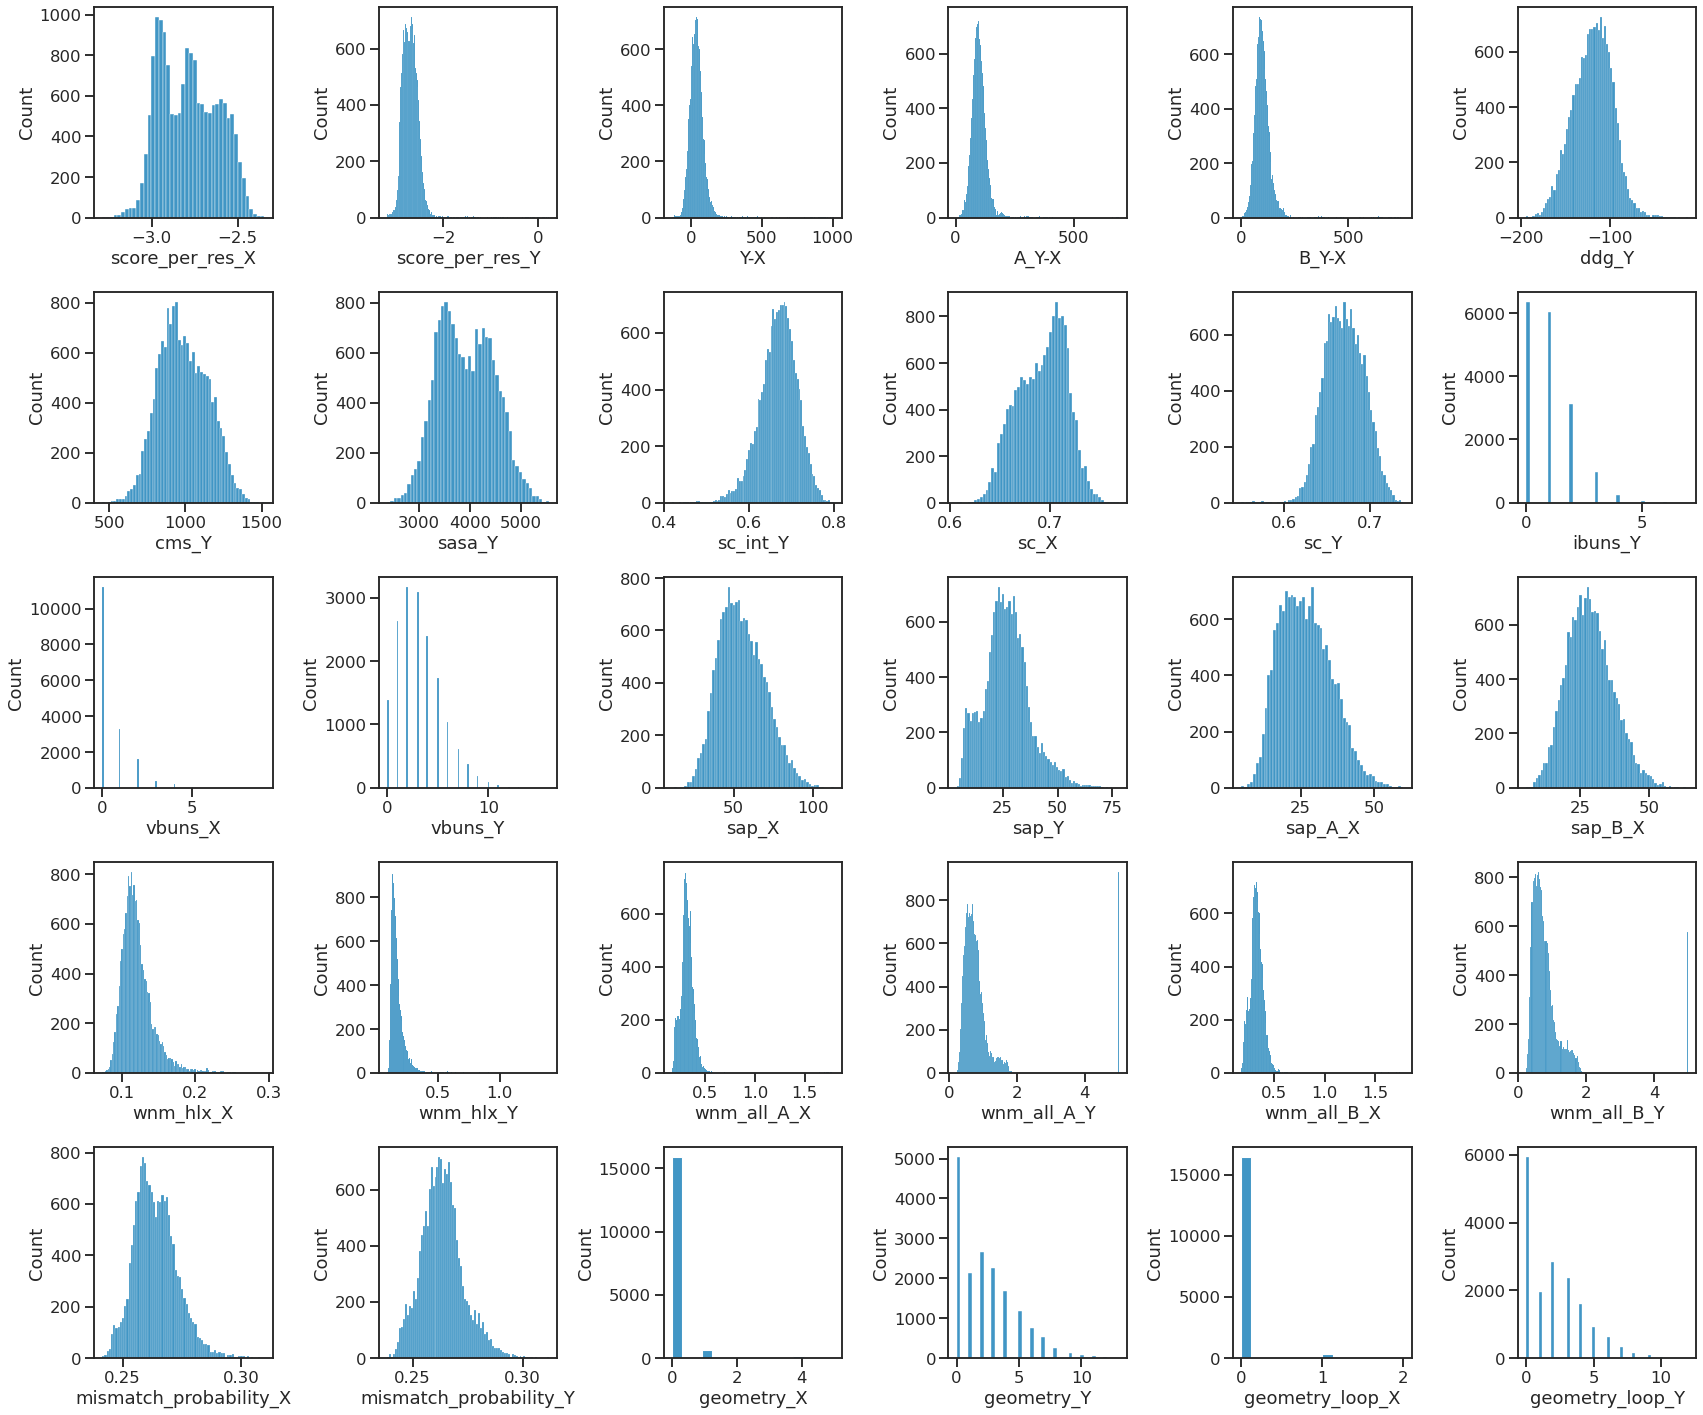

In [9]:
histplot_df(scores_df)

In [10]:
# Filter designs- global filter

cutoffs = [('Y-X', -20, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.7, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

43


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_4/af2_decoys/91d2a6410cb34a621b2661c24d153338d8d607c1c31167de.pdb,-2.867778,-2.917609,-20.331421,83.559937,81.522400,-157.676590,1104.572388,4154.286133,0.721750,0.669879,0.672417,0,1,1,42.794678,16.350658,14.280905,28.513792,0.099144,0.168467,0.194398,0.539628,0.224370,0.585975,0.261916,0.261701,0,0,0,0,X26_3_20_2_ct1_fe
05_two_state/run_4/af2_decoys/d8b28fc59e470649b18ad9c58603558766cb8a08f918da5d.pdb,-2.603336,-2.674793,-23.437805,48.343628,57.432922,-103.154213,816.468262,3276.364258,0.722879,0.696414,0.675315,1,0,0,60.119068,28.112125,29.021944,31.097130,0.105633,0.126949,0.356165,0.425779,0.341785,0.640265,0.279019,0.271952,0,0,0,0,X16_3_18_4_ct6_fe
05_two_state/run_4/af2_decoys/83bc1ffbf717f273e527920705fe833723f0b1a94f8a7810.pdb,-2.551384,-2.640089,-33.353149,25.985931,74.982605,-104.013336,842.431824,3249.924561,0.704770,0.697119,0.660905,0,0,0,60.558701,32.170300,31.455160,29.103540,0.151159,0.193587,0.264334,0.618543,0.218848,0.818989,0.299849,0.300461,0,2,0,2,KH_PO11
05_two_state/run_4/af2_decoys/039b2544785d6b42bc2c09b709dafaa4a6a8919a4a344aba.pdb,-2.769265,-2.865625,-43.940063,60.650269,43.461426,-112.195885,943.523926,3394.622559,0.723329,0.693495,0.671507,1,0,2,64.658737,20.454844,34.460678,30.198116,0.137569,0.195016,0.343538,0.462713,0.307000,0.699833,0.260275,0.258597,0,1,0,0,hDHR64_5CWM
05_two_state/run_4/af2_decoys/432585caffa87becf17a5bce06d05cdb8fdbe7cd9e2fe84e.pdb,-2.857011,-2.935658,-31.458374,63.142639,53.883575,-115.025375,893.676453,3371.385498,0.702451,0.706209,0.698722,1,2,2,61.597660,27.474762,29.464907,32.132748,0.142849,0.133024,0.321560,0.601025,0.308945,0.681715,0.262835,0.263076,0,3,0,3,hDHR71_5CWN
05_two_state/run_4/af2_decoys/8de9470a1f33ffe292050598366d563ff7d149724d8b0882.pdb,-2.768847,-2.865774,-44.198608,60.592896,43.267578,-112.214615,944.025635,3393.214111,0.723371,0.693477,0.671553,1,0,2,64.671249,20.452152,34.464779,30.206446,0.137671,0.195055,0.343361,0.462762,0.307004,0.699893,0.260275,0.258597,0,1,0,0,hDHR64_5CWM
05_two_state/run_4/af2_decoys/ee38704cc7039c6fcfa594803bc46b09104c9fb8e0bf68ea.pdb,-2.724836,-2.810840,-29.585388,20.471619,69.708160,-94.114304,776.564636,3077.473145,0.717770,0.706586,0.712029,1,0,2,31.277954,8.555627,17.805460,13.472490,0.111091,0.124522,0.286203,0.473349,0.213749,0.562545,0.273824,0.270160,0,0,0,0,DHR62
05_two_state/run_4/af2_decoys/988da5702217cbecb6fb0f21a72adb84eec785cb37dee845.pdb,-3.087204,-3.146189,-25.953613,87.344604,87.351929,-157.547272,1226.306152,4580.177246,0.720047,0.716871,0.706362,2,0,0,60.142216,22.181074,33.912575,26.229706,0.121644,0.134130,0.377390,0.556058,0.331155,0.417013,0.255464,0.246774,0,0,0,0,X26_3_24_2_ct12_fe
05_two_state/run_4/af2_decoys/b2362fa41276a4323d2f7afd87509f9d97dfb4c412578d80.pdb,-2.762356,-2.817978,-25.363403,84.474060,77.247620,-152.712433,1161.011230,4313.738281,0.749574,0.702677,0.683877,1,2,1,61.202972,27.232227,34.557156,26.645800,0.139634,0.172435,0.282581,0.819295,0.299474,0.496741,0.256469,0.259716,0,0,0,0,hDHR64_5CWM
05_two_state/run_4/af2_decoys/3243f7a7351de77a454c9b44f28dcbf86cbbe58601430cb0.pdb,-2.674244,-2.730748,-20.341492,88.241943,67.860474,-138.143494,1051.845581,3838.187744,0.751393,0.718480,0.716331,0,1,1,47.807575,17.666145,24.860628,22.946987,0.106644,0.115304,0.290575,0.680746,0.283112,0.892737,0.257913,0.254974,0,1,0,1,X22_3_16_4_ct4_fa


In [23]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_4/selected/AF2_DHR62/'
copy_designs(global_df, out_dir)

In [11]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_4/af2_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

7692


#### Analyze and filter MSD starting from design models ####

In [12]:
output_path = "05_two_state/run_4"
output_file = os.path.join(output_path, "design_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y,remodel_after_loop_A,remodel_before_loop_A
05_two_state/run_4/design_decoys/a48921b52156a61e5f72978326a8cb30b2c2c4b5ea2da521.pdb,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,106.714005,48.640388,48.715912,loop_match,loop_remodel,11.312505,253.735657,403.629120,...,1,10,0.434035,0.371207,0.420515,0.866305,0.134013,0.144486,NaN,NaN
05_two_state/run_4/design_decoys/c11b52bcaae3c8a9ed31313eaf58fc8321bf01c6bfd732d2.pdb,XAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAA...,755.069824,58.997833,58.997833,loop_remodel,loop_match,-1.000000,623.628357,929.301819,...,0,1,0.309753,0.862140,0.301933,1.539708,0.131618,0.134246,1.0,2.0
05_two_state/run_4/design_decoys/bb924d309a2542ffd0b207ef561ebdc807b05331f8410253.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,347.873260,72.230377,69.135925,loop_match,loop_match,-1.000000,576.293701,839.861511,...,1,4,0.341331,0.832883,0.283065,1.451353,0.115889,0.112387,NaN,NaN
05_two_state/run_4/design_decoys/450e802e39e111058a0b1df8340e3d3e0146fc768dfb4aca.pdb,XAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAAGBBA...,XAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAAGBBA...,249.750427,62.044983,62.044983,loop_match,loop_remodel,-1.000000,508.394562,759.256714,...,0,6,0.352655,0.843092,0.303675,0.742573,0.131707,0.189835,NaN,NaN
05_two_state/run_4/design_decoys/7a9ae020f3273bd687cdd57533df26e40fb770c1254f0f55.pdb,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,408.687531,52.802925,54.344105,loop_remodel,loop_match,-1.000000,406.764313,608.935974,...,2,0,0.320009,5.000000,0.284822,0.831876,0.143212,0.109179,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_4/design_decoys/f633b7b4a6011b5b4d1a518e391ececd3a5923ee4730dcec.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,951.809143,74.775955,74.775955,loop_match,loop_match,-1.000000,498.185333,828.041138,...,2,2,0.346171,0.621232,0.362860,1.060351,0.134899,0.126395,NaN,NaN
05_two_state/run_4/design_decoys/bc548d1301becb2cb81c5e962fcc00332ba7159294a893aa.pdb,XAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAABAAB...,XAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAABAAB...,105.116508,51.600029,51.600029,loop_match,loop_match,-1.000000,526.736267,678.195801,...,0,1,0.370927,0.895443,0.282535,1.079398,0.092409,0.158851,NaN,NaN
05_two_state/run_4/design_decoys/cff3fd88e549985aab0cf3d139c9cb636e223be87de3f3bd.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,747.694946,74.775955,74.775955,loop_match,loop_match,-1.000000,508.725494,659.838989,...,1,2,0.309955,5.000000,0.416006,1.639579,0.132041,0.130152,NaN,NaN
05_two_state/run_4/design_decoys/4a24e2f0e41fdfe566e0b3bca9fcf06c15b01b9e47a3776f.pdb,XAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAA...,461.588531,58.330166,403.257355,loop_remodel,loop_remodel,0.000016,685.046814,840.829773,...,4,6,0.347207,0.610786,0.337765,0.454498,0.174189,0.178457,1.0,2.0


In [13]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

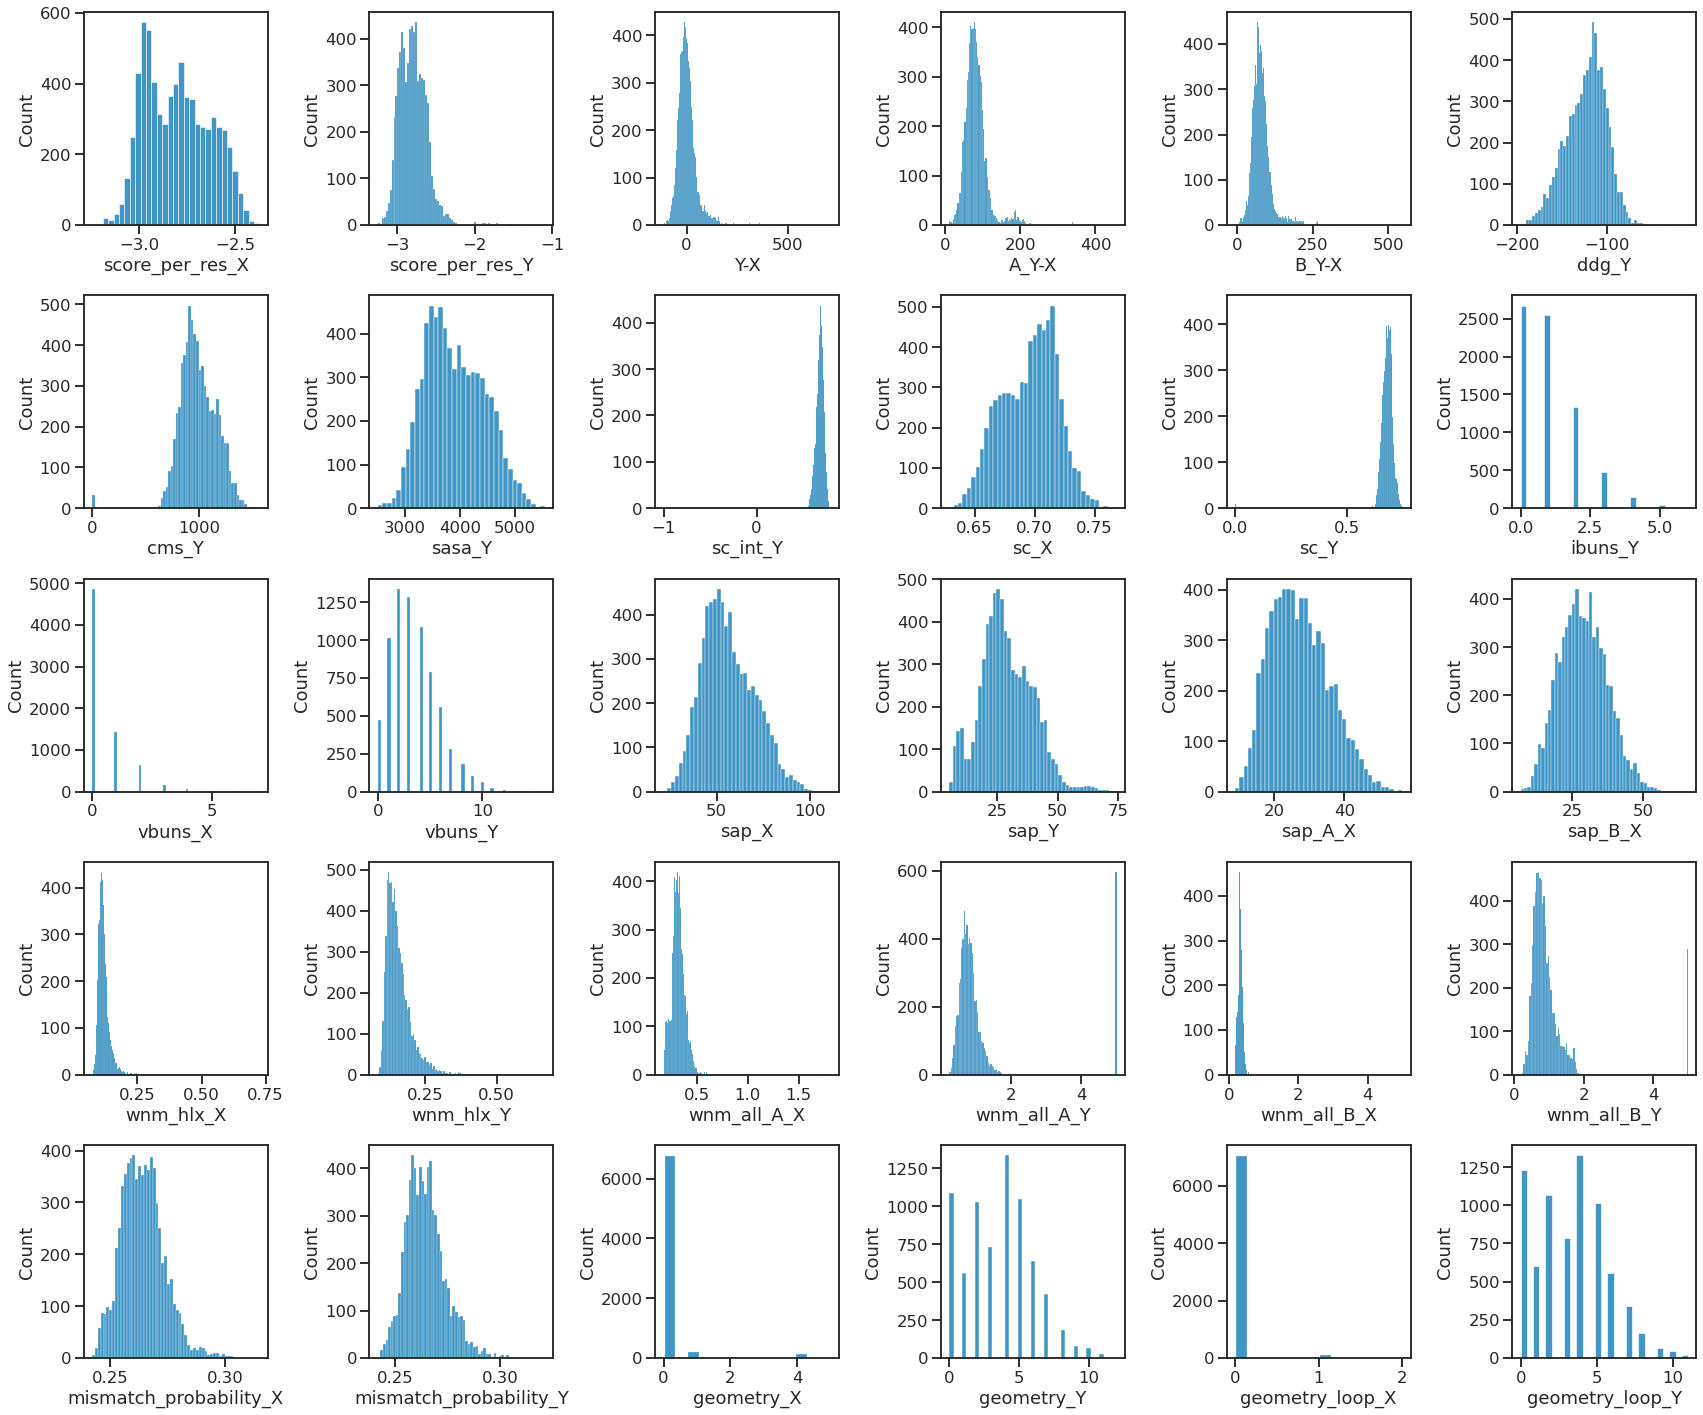

In [14]:
histplot_df(scores_df)

In [15]:
# Filter designs- global filter

cutoffs = [('Y-X', -20, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.7, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

82


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_4/design_decoys/4198670558e8cde9be00b8ee414cfa57324f319d09ef0b78.pdb,-2.907585,-3.004829,-39.675781,21.425110,83.729675,-117.716232,897.307251,3490.555908,0.708919,0.684622,0.679684,3,0,0,50.660324,14.450290,26.940159,23.720146,0.128050,0.131515,0.208714,0.959647,0.230206,0.920702,0.268454,0.266216,0,3,0,3,X26_3_20_2_ct1_fe
05_two_state/run_4/design_decoys/6eac99c7854cd326d4ba37075e084ca449bd5eb3968e1ce5.pdb,-2.793045,-2.894312,-40.506836,37.846497,59.557587,-106.276154,877.848755,3306.868652,0.701630,0.714561,0.706953,1,0,1,54.648235,21.426052,30.666885,23.981373,0.123937,0.147924,0.274550,0.484511,0.222622,0.997752,0.272547,0.271371,0,1,0,1,hDHR71_5CWN
05_two_state/run_4/design_decoys/0d73fdfc1968aa71b7b2a2d09936b725213509716e3f44aa.pdb,-2.962232,-3.097230,-60.478882,73.730103,54.691895,-158.264862,1197.727661,4553.364258,0.700410,0.691375,0.665864,0,0,1,55.848351,29.312408,30.993229,24.855137,0.113361,0.118568,0.347298,0.708372,0.337440,0.813411,0.266302,0.262619,0,4,0,4,X23_4_26_3_ct8_fc
05_two_state/run_4/design_decoys/bb8496e1c213ca3f46ebfd452a02a8ccc4d5edc74849d827.pdb,-2.800442,-2.856678,-22.494751,53.459717,66.731262,-108.313202,880.098389,3356.257080,0.736672,0.712046,0.693090,0,0,2,50.368561,24.859169,25.286974,25.081573,0.119891,0.142706,0.275481,0.473236,0.275078,0.944766,0.261502,0.262367,0,0,0,0,hDHR71_5CWN
05_two_state/run_4/design_decoys/c11c6c72fd529a5a1a42dc4b3e26697c4d95293fb77459ed.pdb,-2.779625,-2.827227,-21.706543,56.290283,77.877869,-119.696411,982.029175,3854.915771,0.702178,0.715900,0.694506,1,0,2,52.501942,20.582932,18.023163,34.478764,0.122192,0.162641,0.283885,0.667544,0.299228,0.867003,0.257879,0.255591,0,1,0,1,hDHR64_5CWM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_4/design_decoys/ad2f93f0e692301e30f7a26e3f682c4e3bcdbddea9a1f6a1.pdb,-2.826653,-2.882841,-20.227478,64.144135,65.358704,-110.849922,923.932373,3653.914062,0.717737,0.720634,0.720618,2,0,0,54.791565,25.978992,27.800070,26.991501,0.115020,0.104423,0.307814,0.696691,0.313464,0.547360,0.263741,0.265491,0,4,0,4,X22_3_16_4_ct4_fa
05_two_state/run_4/design_decoys/c11b82ee30fd49ab08c16fa5d44c9fab2f333e03ebc36cfa.pdb,-2.532075,-2.604624,-30.760742,80.977905,74.967255,-116.332275,1166.132568,4514.714844,0.714309,0.646370,0.648912,1,0,1,43.645924,22.576372,18.900663,24.745226,0.105207,0.121545,0.398221,0.441535,0.328407,0.440001,0.259463,0.261171,0,2,0,2,X27_3_19_4_ct3_fe
05_two_state/run_4/design_decoys/b7b99e1125477639f29972b0aecd270783a3c16671f8504d.pdb,-2.519420,-2.699425,-70.561646,71.513672,38.054016,-138.367767,1139.229004,4063.659668,0.727963,0.648642,0.677454,3,1,2,41.502960,23.273634,23.808552,17.694435,0.136503,0.172781,0.360581,0.805450,0.327609,0.497025,0.275303,0.276604,0,4,0,4,X18_4_23_4_ct3_ff
05_two_state/run_4/design_decoys/e2293e86323fd3b47faa17a877d0a8df2ac700d3d80f8b6d.pdb,-2.749673,-2.958945,-68.641418,40.487946,31.179047,-115.816017,896.241760,3441.612061,0.703074,0.691533,0.688382,0,0,0,41.997318,16.612761,19.349089,22.648216,0.109610,0.118136,0.448661,0.857045,0.357550,0.866756,0.259212,0.260109,0,0,0,0,X19_3_17_2_ct9_fe


In [35]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_4/selected/des_DHR62/'
copy_designs(global_df, out_dir)

In [16]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_4/des_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

3190


In [20]:
from more_itertools import ichunked

with open('05_two_state/run_4/af2_selected.list', 'r') as sel_f:
    selected = sel_f.read().splitlines()

with open('05_two_state/run_4/silent.tasks', 'w') as tasks_f:
    for i, lines in enumerate(ichunked(selected, 50)):
        tasks_f.write(f'05_two_state/build_dimer_silent.py 05_two_state/run_4/selected_for_af2/silents/af2_{i}.silent ' + ' '.join(lines) + '\n')

with open('05_two_state/run_4/des_selected.list', 'r') as sel_f:
    selected = sel_f.read().splitlines()

with open('05_two_state/run_4/silent.tasks', 'a') as tasks_f:
    for i, lines in enumerate(ichunked(selected, 50)):
        tasks_f.write(f'05_two_state/build_dimer_silent.py 05_two_state/run_4/selected_for_af2/silents/des_{i}.silent ' + ' '.join(lines) + '\n')

In [22]:
print("sbatch -a 1-$(cat 05_two_state/run_4/build_dimer_silent.tasks | wc -l) 05_two_state/run_4/build_dimer_silent.sh")
print('cat 05_two_state/run_4/selected_for_af2/silents/af2_*.silent > 05_two_state/run_4/selected_for_af2/af2_dimers.silent')
print('cat 05_two_state/run_4/selected_for_af2/silents/des_*.silent > 05_two_state/run_4/selected_for_af2/des_dimers.silent')

sbatch -a 1-$(cat 05_two_state/run_4/build_dimer_silent.tasks | wc -l) 05_two_state/run_4/build_dimer_silent.sh
cat 05_two_state/run_4/selected_for_af2/silents/af2_*.silent > 05_two_state/run_4/selected_for_af2/af2_dimers.silent
cat 05_two_state/run_4/selected_for_af2/silents/des_*.silent > 05_two_state/run_4/selected_for_af2/des_dimers.silent
